<a href="https://colab.research.google.com/github/Volt-github24/Groupe-4-info-l3-datasciences-tutoriels/blob/main/Random_Forest_%26_Boosting_Implementation_(11).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFOL3 - SDD- UY1 - Departement d'informatique**


# **IMPLEMENTATION DE RANDOM FOREST & BOOSTING WITH PYTHON**


                                   
### Noms des membres du groupe (**Groupe 4**) :
  1. NOUCHEN TCHAMBA Parnell Voltaire - 19M2326
  2. DJEUMEZA DONGMO Julie Merveille - 19M2105
  3. MADJOU Alvine Patricia - 19M2103
  4. NAKAM YOPDUP Manuella Kristeva - 19M2233
  

Connexion avec le drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

IMPORTATION DES BIBLIOTHEQUES ET CHARGEMENT DU JEU DE DONNEES

In [ ]:
#Importation des bibliotheques
import pandas as pd
import numpy as np
from pprint import pprint
import scipy.stats as sps


#on charge le dataset sans charger l'entete
dataset = pd.read_csv('/content/drive/MyDrive/ML/agaricus-lepiota.data',header=None)
dataset = dataset.sample(frac=1)

#on attribue de nouveaux noms aux differentes colonne
dataset.columns = ['target','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing',
'gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring',
'stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']


#Visualisons les 5 premieres lignes de notre jeu de donnee
dataset.head()

,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
7107,p,f,s,e,f,y,f,c,n,b,...,k,p,p,p,w,o,e,w,v,p
25,p,f,s,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,n,v,g
2583,e,f,f,n,t,n,f,c,b,n,...,s,p,p,p,w,o,p,k,v,d
4544,p,f,f,g,f,f,f,c,b,p,...,k,p,p,p,w,o,l,h,v,d
6435,p,f,s,n,f,s,f,c,n,b,...,k,p,p,p,w,o,e,w,v,p


Notre dataset comporte les cateristiques des differents champignons de la famille des agaricus et des lepiota

**IMPLEMENTATION** **DES** **RANDOM** **FORESTS** **FROM** **SCRATCH** AVEC PYTHON

In [ ]:
#Fonction qui calul de l'enthropie d'un attribut
def entropy(target_col):
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy


#Fonction qui calcul du gain d'information d'un attribut
def InfoGain(data,split_attribute_name,target_name="target"):
    #Calcul de l'enthropie du jeu de donnees
    total_entropy = entropy(data[target_name])
    #Calculate the values and the corresponding counts for the split attribute
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)
    #Calcul de l'enthropie ponderee
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
    #Calculate the information gain
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain



# Definition de la fonction qui construit l'arbre de decision
def ID3(data,originaldata,features,target_attribute_name="target",parent_node_class = None):
    #Definition du critere d'arret
    
    #Si toute les etiquettes sont identiques on retourne ctte etiquette
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0] 
    #si le jeu de donnee est vide on retourne l'etiquette majoritaire 
    elif len(data)==0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],return_counts=True)[1])]
    
    elif len(features) ==0:
        return parent_node_class
    #sinon on construit l'arbre
    else:
        #Set the default value for this node --> The mode target feature value of the current node
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]
        features = np.random.choice(features,size=np.int(np.sqrt(len(features))),replace=False)
        
        #On selectionne l'attribut qui separe le mieux le jeu de donnees c'est a dire celui qui le plus grand gain d'information
        item_values = [InfoGain(data,feature,target_attribute_name) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        
        # On commence la construction de l'arbre en mettant a la racine l'attribut qui a eu le gain d'information maximale
        tree = {best_feature:{}}
        #On enleve dans la liste des caracteristique l'attribut qui a eu le gain d'information maximale
        features = [i for i in features if i != best_feature]
        #On cree une branche en dessous de la racine pour chacune des valeurs possible de l'attribut a la racine
        for value in np.unique(data[best_feature]):
            value = value
            #On divise le jeu de donnees en fonction de chacune des valeurs de l'attribut ayant le gain d'infos maximal
            sub_data = data.where(data[best_feature] == value).dropna()
            #On fait de la recursion en apelant la fonction ID3 sur le sous jeu de donnees forme
            subtree = ID3(sub_data,dataset,features,target_attribute_name,parent_node_class)
            #On ajoute le sous arbre forme a partir du sous jeu de donnee en dessous de la racine 
            tree[best_feature][value] = subtree
        return(tree)
    
    

def predict(query,tree,default = 'p'):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]]
            except:
                return default
            result = tree[key][query[key]]
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result
            

#Fonction qui divise le jeu de donnees en jeu d'entrainement(75%) et jeu de test(25%)
def train_test_split(dataset):
    training_data = dataset.iloc[:round(0.75*len(dataset))].reset_index(drop=True) #We drop the index respectively relabel the index
    #starting form 0, because we do not want to run into errors regarding the row labels / indexes
    testing_data = dataset.iloc[round(0.75*len(dataset)):].reset_index(drop=True) 
    return training_data,testing_data


training_data = train_test_split(dataset)[0] # Creation du jeu d'entrainement  
testing_data = train_test_split(dataset)[1] # Creation du jeu de test


# Entrainement du model Rndom Forest

def RandomForest_Train(dataset,number_of_Trees):
  
    random_forest_sub_tree = []
    #On va cree n models
    for i in range(number_of_Trees):
        #On cree a chaque fois un  jeu de donnee par la methode bootstrap
        bootstrap_sample = dataset.sample(frac=1,replace=True)
        #On divise ensuite le jeu de donnee obtenu en jeu d'enrainement et em jeu de test 
        bootstrap_training_data = train_test_split(bootstrap_sample)[0]
        bootstrap_testing_data = train_test_split(bootstrap_sample)[1]
        #Puis son construit l'arbre de decision avec le jeu d'entrainement
        random_forest_sub_tree.append(ID3(bootstrap_training_data,bootstrap_training_data,bootstrap_training_data.drop(labels=['target'],axis=1).columns))
    return random_forest_sub_tree #On retourne l'ensemble des n arbres de decision formé


#On entraine le modele sur notre jeu de donnees avec comme nombre d'arbre egale a 50 
random_forest = RandomForest_Train(dataset,50)


#Fonction de prediction d'une nouvelle instance 

def RandomForest_Predict(query,random_forest,default='p'):
    predictions = []
    for tree in random_forest:
        predictions.append(predict(query,tree,default))
    return sps.mode(predictions)[0][0]


query = testing_data.iloc[0,:].drop('target').to_dict() # observation de test
query_target = testing_data.iloc[0,0] # Etiquette de l'observation de test
print('target: ',query_target)
prediction = RandomForest_Predict(query,random_forest)

print('prediction: ',prediction)


# Fonction de test du modele
def RandomForest_Test(data,random_forest):
    data['predictions'] = None
    for i in range(len(data)):
        query = data.iloc[i,:].drop('target').to_dict()
        data.loc[i,'predictions'] = RandomForest_Predict(query,random_forest,default='p')
    accuracy = sum(data['predictions'] == data['target'])/len(data)*100 # calcul du taux de generalisation
    print('The prediction accuracy is: ',sum(data['predictions']== data['target'])/len(data)*100,'%')
    return accuracy

RandomForest_Test(testing_data,random_forest)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


target:  p
prediction:  p
The prediction accuracy is:  90.94042343673068 %


90.94042343673068

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The prediction accuracy is:  86.50910881339242 %
The prediction accuracy is:  88.82323978335795 %
The prediction accuracy is:  97.83357951747908 %
The prediction accuracy is:  96.06105366814377 %
The prediction accuracy is:  89.7095027080256 %
The prediction accuracy is:  88.82323978335795 %
The prediction accuracy is:  86.41063515509602 %
The prediction accuracy is:  88.42934515017234 %
The prediction accuracy is:  86.41063515509602 %
The prediction accuracy is:  90.49729197439686 %
The prediction accuracy is:  92.26981782373215 %
The prediction accuracy is:  90.74347612013787 %
The prediction accuracy is:  88.97095027080256 %
The prediction accuracy is:  90.89118660758247 %
The prediction accuracy is:  89.95568685376661 %
The prediction accuracy is:  90.34958148695223 %
The prediction accuracy is:  90.10339734121122 %
The prediction accuracy is:  91.2850812407681 %
The prediction accuracy is:  90.89118660758247 %
The prediction accuracy is:  91.1866075824717 %
The prediction accuracy

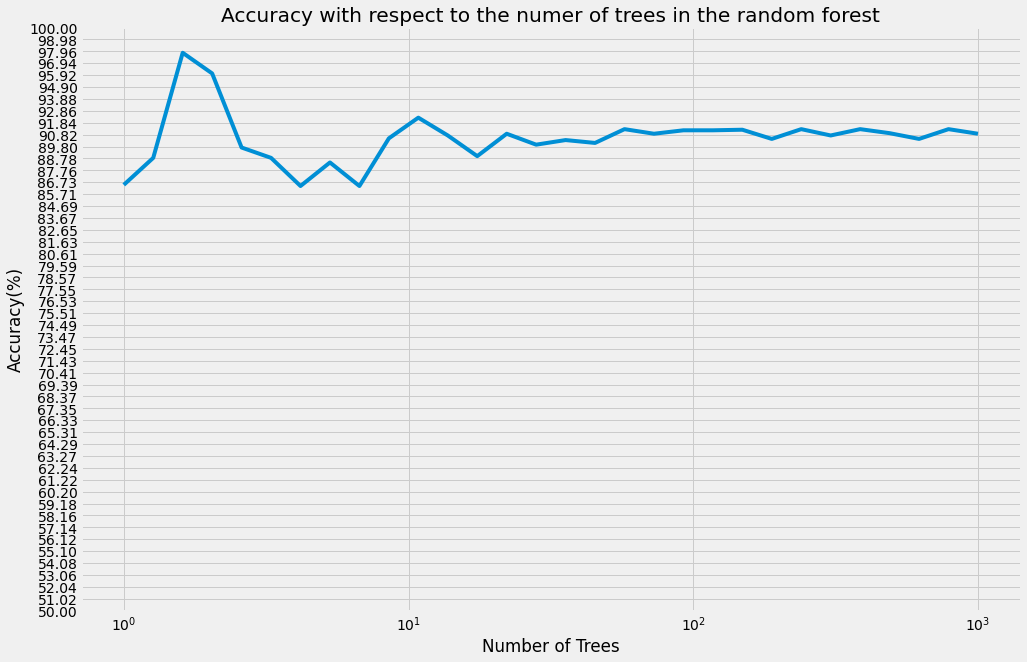

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,10))
ax0 = fig.add_subplot(111)
accuracy = []
for i in range(1,11,1):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))
    
for i in range(10,110,10):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))
    
for i in range(100,1100,100):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))
print(accuracy)
ax0.plot(np.logspace(0,3,30),accuracy)
ax0.set_yticks(np.linspace(50,100,50))
ax0.set_title("Accuracy with respect to the numer of trees in the random forest")
ax0.set_xscale('log')
ax0.set_xlabel("Number of Trees")
ax0.set_ylabel('Accuracy(%)')
plt.show()

On constate que le dataset contient beaucoup d'observations

 **IMPLEMENTATION DES RANDOM FORESTS AVEC SKLEARN **

In [ ]:
from sklearn.ensemble import RandomForestClassifier #on importe le classifieur Random Forests  de sklearn
from sklearn.preprocessing import LabelEncoder #Encode les étiquettes cibles avec une valeur comprise entre 0 et n_classes-1
from sklearn.model_selection import cross_validate #validation croisee
#transformer les observations categorielles en observations numeriques
for label in dataset.columns:
  dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])
X = dataset.drop(['target'],axis=1)
Y = dataset['target']
# on initialise le model a 100 arbres et on utilise l'entropie comme critere de division
Random_Forest_model = RandomForestClassifier(n_estimators=100,criterion="entropy") 
#on calcule le taux de generalisation en utilisant la validation croisee validation
accuracy = cross_validate(Random_Forest_model,X,Y,cv=10)['test_score']
print('The accuracy is: ',sum(accuracy)/len(accuracy)*100,'%')

The accuracy is:  100.0 %


On constate que le taux de generalisation est de 100% c'est a dire que le randomforest permet de faire de bonne prediction sur des modeles avec beaucoup de donnees

**IMPLEMENTATION DU BOOSTING FROM SCRATCH AVEC PYTHON**

Pour cette implementation, nous utiliserons comme modele simple, les arbres de decision, comme la pertinence des algorithmes de boosting reside dans la conmbinaison des modeles simples plutot que la construction de ces modeles simples, nous ferons l'implementation d'un arbre de decision avec sklearn.

In [ ]:
"""
Create a Decision Stump
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import scipy.stats as sps

# Load in the data and define the column labels

dataset = pd.read_csv('/content/drive/MyDrive/Datas/mushroom.csv',header=None)
dataset = dataset.sample(frac=1)
dataset.columns = ['target','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing', 'gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']

# Encode the feature values from strings to integers since the sklearn DecisionTreeClassifier only takes numerical values

for label in dataset.columns:
  dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])

Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1) # precision que l'arbre s'arrete à une seule couche
X = dataset.drop('target',axis=1) # X prend toutes les colonnes sauf la colonne qui renseigne sur les classes
Y = dataset['target'].where(dataset['target']==1,-1)

predictions = np.mean(cross_validate(Tree_model,X,Y,cv=100)['test_score'])
print('The accuracy is: ',predictions*100,'%')




The accuracy is:  73.06805179162903 %


On voit la que la precision n'est que de 73%, chose qu'on peut ameliorer avec un algorithme de type boosting, 
Faisons le from scratch avec python

Streaming output truncated to the last 5000 lines.
6146    0
4487    1
       ..
2794    0
6567    1
1277    0
3452    1
7947    0
Name: misclassified, Length: 8124, dtype: int64 difference
2186    1
4875    1
4058    1
6146    0
4487    1
       ..
2794    1
6567    1
1277    1
3452    1
7947    0
Name: evaluation, Length: 8124, dtype: int64 2186    0
4875    0
4058    0
6146    1
4487    0
       ..
2794    0
6567    0
1277    0
3452    0
7947    1
Name: misclassified, Length: 8124, dtype: int64 difference
2186    1
4875    1
4058    1
6146    0
4487    1
       ..
2794    1
6567    0
1277    1
3452    1
7947    0
Name: evaluation, Length: 8124, dtype: int64 2186    0
4875    0
4058    0
6146    1
4487    0
       ..
2794    0
6567    1
1277    0
3452    0
7947    1
Name: misclassified, Length: 8124, dtype: int64 difference
2186    1
4875    0
4058    0
6146    1
4487    0
       ..
2794    1
6567    0
1277    1
3452    0
7947    1
Name: evaluation, Length: 8124, dtype: int64 2186   

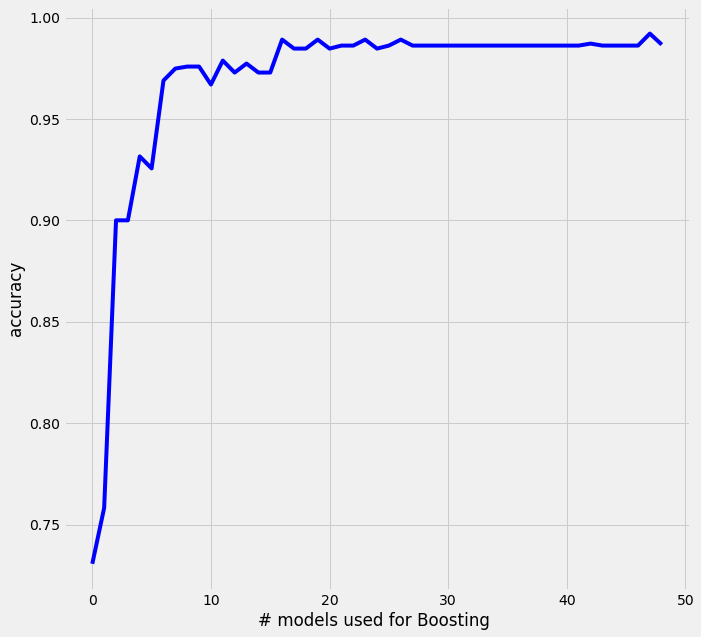

In [ ]:
class Boosting:

  # methode init, initialisation de quelques variables necessaires
  def __init__(self,dataset,T,test_dataset):
    self.dataset = dataset # le jeu de donnee utilisé pour l'entrainement
    self.T = T # nombre de modeles à construire
    self.test_dataset = test_dataset # le jeu de donnee utilisé pour le test
    self.alphas = None # les differents poids des differents modeles (Ci) construits
    self.models = None # les differents models en question Ci
    self.accuracy = [] # les differentes precisions des modeles (Ci)
    self.predictions = None # Les predictions en elles meme.

  # fonction pour l'entrainement du modele de melange
  def fit(self):

        # Set the descriptive features and the target feature
        X = self.dataset.drop(['target'],axis=1) # on prends tous les attributs sauf la colonne de 'target'
        Y = self.dataset['target'].where(self.dataset['target']==1,-1) #

        # Initialize the weights of each sample with wi = 1/N and create a dataframe in which the evaluation is computed
        Evaluation = pd.DataFrame(Y.copy()) #
        Evaluation['weights'] = 1/len(self.dataset) # Set the initial weights w = 1/N
        

        # Run the boosting algorithm by creating T "weighted models"
        
        alphas = [] 
        models = []
        
        for t in range(self.T):

            # Train the Decision Stump(s)
            Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1) # Mind the deth one --> Decision Stump
            
            # We know that we must train our decision stumps on weighted datasets where the weights depend on the results of
            # the previous decision stumps. To accomplish that, we use the 'weights' column of the above created 
            # 'evaluation dataframe' together with the sample_weight parameter of the fit method.
            # The documentation for the sample_weights parameter sais: "[...] If None, then samples are equally weighted."
            # Consequently, if NOT None, then the samples are NOT equally weighted and therewith we create a WEIGHTED dataset 
            # which is exactly what we want to have.
            model = Tree_model.fit(X,Y,sample_weight=np.array(Evaluation['weights']))  # on passe dans sample_weight une liste de poids des echantillons (probabilites) qui ponderent les observations de X
            
            # Append the single weak classifiers to a list which is later on used to make the 
            # weighted decision
            models.append(model) # ajout de ce modele a la liste des modeles
            predictions = model.predict(X) # calcul de predictions 
            score = model.score(X,Y) # calcul du score, compare les valeurs predites aux valeurs reelles

            # Add values to the Evaluation DataFrame
            Evaluation['predictions'] = predictions
            Evaluation['evaluation'] = np.where(Evaluation['predictions'] == Evaluation['target'],1,0) # retourne une matrice de 0 et 1, si 1 alors cest une observation bien classee, 0 sinon
            Evaluation['misclassified'] = np.where(Evaluation['predictions'] != Evaluation['target'],1,0) # retourne une matrice de 0 et 1, si 1 alors cest une observation mal classee, 1 sinon
            print(Evaluation['evaluation'], Evaluation['misclassified'], 'difference') #juste un print d'eclaircissement

            # Calculate the misclassification rate and accuracy
            accuracy = sum(Evaluation['evaluation'])/len(Evaluation['evaluation']) #retourne un certain pourcentage de ceux bien classe sur le total
            misclassification = sum(Evaluation['misclassified'])/len(Evaluation['misclassified']) #retourne un certain pourcentage de ceux mal classes sur le total

            
            # Caculate the error
            err = np.sum(Evaluation['weights']*Evaluation['misclassified'])/np.sum(Evaluation['weights']) # calcul de l'erreur du modele t
 
   
            # Calculate the alpha values
            alpha = np.log((1-err)/err) # qui correspond a la ponderation du modele t
            alphas.append(alpha) # ajout de cette ponderation a la liste des ponderations

              # Update the weights wi --> These updated weights are used in the sample_weight parameter
            # for the training of the next decision stump. 
            Evaluation['weights'] *= np.exp(alpha*Evaluation['misclassified'])

            #print('The Accuracy of the {0}. model is : '.format(t+1),accuracy*100,'%')
            #print('The missclassification rate is: ',misclassification*100,'%')
        
        self.alphas = alphas # je sauvegarde les poids de models 
        self.models = models # je sauvegarde les models

  # fonction pour predire la classe d'une nouvelle donnee
  def predict(self):
        X_test = self.test_dataset.drop(['target'],axis=1).reindex(range(len(self.test_dataset))) # juste pour mettre des index alant de 0 à la taille du jeu de données
        Y_test = self.test_dataset['target'].reindex(range(len(self.test_dataset))).where(self.dataset['target']==1,-1) # je constitue la liste des classes (1 ou -1) si cest pas 1 je mets -1 pour lautre classe en fait
    
        # With each model in the self.model list, make a prediction 
        
        accuracy = []
        predictions = []
        
        for alpha,model in zip(self.alphas,self.models):
            prediction = alpha*model.predict(X_test) # Je fais la prediction pour chaque valeur pour le model i en ponderant par le poids du model i
            predictions.append(prediction) # je garde les predicitions de ces modeles la dans ma liste predictions
            self.accuracy.append(np.sum(np.sign(  np.sum(np.array(predictions),axis=0))==Y_test.values)/len(predictions[0])) # pour le calcul de la precision de chacun des models Ci
        self.predictions = np.sign(np.sum(np.array(predictions),axis=0)) # calcul du retour de la fonction sign


# Testons notre model de boosting

number_of_base_learners = 50 # on defini le nombre de modeles que l'on va entrainer

fig = plt.figure(figsize=(10,10)) #pour la figure
ax0 = fig.add_subplot(111)

for i in range(number_of_base_learners):
    model = Boosting(dataset,i,dataset)
    model.fit()
    model.predict()

ax0.plot(range(len(model.accuracy)),model.accuracy,'-b') # on affiche le graphe du modele fonction de son taux de generalisation, et donc une courbe qui converge vers 1
ax0.set_xlabel('# models used for Boosting ')
ax0.set_ylabel('accuracy')
#print('With a number of ',number_of_base_learners,'base models we receive an accuracy of ',model.accuracy[-1]*100,'%')    
                 
plt.show()   


**On voit la que pour les tous premiers modeles, les taux de generalisation sont tres tres bas, mais lorsqu'on arrive sur les modeles entrainés à la fin, le taux de generalisation est tres important et tant vers 1.**

**IMPLEMENTATION DU BOOSTING AVEC SKLEARN**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier #Importation du classifier
from sklearn.preprocessing import LabelEncoder #Importation de l'encodeur d'etiquettes
from sklearn.tree import DecisionTreeClassifier #Importation du classifier d'arbres de decision

# On parcourt les etiquettes et on normalise en transformant les donnees categorielles de depart en donnees
#numeriques a partir de la fonction LabelEncoder().fit().transform()
for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])

X = dataset.drop(['target'],axis=1) # Suppression des etiquettes pour ne conserver que les observations
Y = dataset['target'] # On conserve les etiquettes

model = DecisionTreeClassifier(criterion='entropy',max_depth=1) # Construction d'un classifieur d'AD 
AdaBoost = AdaBoostClassifier(base_estimator= model,n_estimators=400,learning_rate=1)

# Construction s'un classifieur Adaboost a partir de l'algorithme d'amplification discrète SAMME 
#AdaBoost = AdaBoostClassifier(n_estimators=400,learning_rate=1,algorithm='SAMME')

# Construction d'un classificateur boosté à partir de l'ensemble d'apprentissage 
AdaBoost.fit(X,Y)

#Calcul de la précision moyenne sur les données de test et les étiquettes données
prediction = AdaBoost.score(X,Y)

# Affichage de la la prediction precedemment calculee
print('The accuracy is: ',prediction*100,'%')

The accuracy is:  100.0 %
